# Transpose Convolutional Networks

### Step 1 - Import libraries

In [1]:
# Tensorflow / Keras
import tensorflow as tf # for building Neural Networks
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model # for assembling a Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Conv2D, Conv2DTranspose # for adding layers to our Neural Network
from tensorflow.keras.utils import plot_model # for plotting model diagram


# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version


# Sklearn
import sklearn # for model evaluation
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples


# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib # for showing images
import matplotlib.pyplot as plt # for showing images
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version


# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
#print(main_dir)

Tensorflow/Keras: 2.7.0
pandas: 1.3.4
numpy: 1.21.4
sklearn: 1.0.1
OpenCV: 4.5.5
matplotlib: 3.5.1
graphviz: 0.19.1


### Step 2 - Load and Process Caltech101 image dataset
- Source and Licence: http://www.vision.caltech.edu/Image_Datasets/Caltech101/
- Required Refrence: L. Fei-Fei, R. Fergus and P. Perona. Learning generative visual models from few training examples: an incremental Bayesian approach tested on 101 object categories. IEEE. CVPR 2004, Workshop on Generative-Model Based Vision. 2004

In [2]:
# Specify the location of images after you have downloaded them
ImgLocation=main_dir+"/data/101_ObjectCategories/"

# List image categories we are interested in (Only "panda" this time)
#LABELS = set(["dalmatian", "hedgehog", "llama", "panda"])
CATEGORIES = set(["panda"])

# Create a list to store image paths
ImagePaths=[]
for category in CATEGORIES:
    for image in list(os.listdir(ImgLocation+category)):
        ImagePaths=ImagePaths+[ImgLocation+category+"/"+image]
        
# Load images and resize. We will need images in 64 x 64 and 256 x 256 pixels.
data_lowres=[]
data_hires=[]
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_lowres = cv2.resize(image, (64, 64))
    image_hires = cv2.resize(image, (256, 256))
    data_lowres.append(image_lowres)
    data_hires.append(image_hires)
    
# Convert image data to numpy array and standardize values (divide by 255 since RGB values ranges from 0 to 255)
data_lowres = np.array(data_lowres, dtype="float") / 255.0
data_hires = np.array(data_hires, dtype="float") / 255.0

# Show data shape
print("Shape of whole data_lowres: ", data_lowres.shape)
print("Shape of whole data_hires: ", data_hires.shape)


# ---- Create training and testing samples ---
X_train, X_test, Y_train, Y_test = train_test_split(data_lowres, data_hires, test_size=0.2, random_state=0)

# Print shapes
# Note, model input must have a four-dimensional shape [samples, rows, columns, channels]
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

Shape of whole data_lowres:  (38, 64, 64, 3)
Shape of whole data_hires:  (38, 256, 256, 3)
Shape of X_train:  (30, 64, 64, 3)
Shape of Y_train:  (30, 256, 256, 3)
Shape of X_test:  (8, 64, 64, 3)
Shape of Y_test:  (8, 256, 256, 3)


#### Display a few images from our train and test datasets

##### Low resolution (64 x 64 pixels)

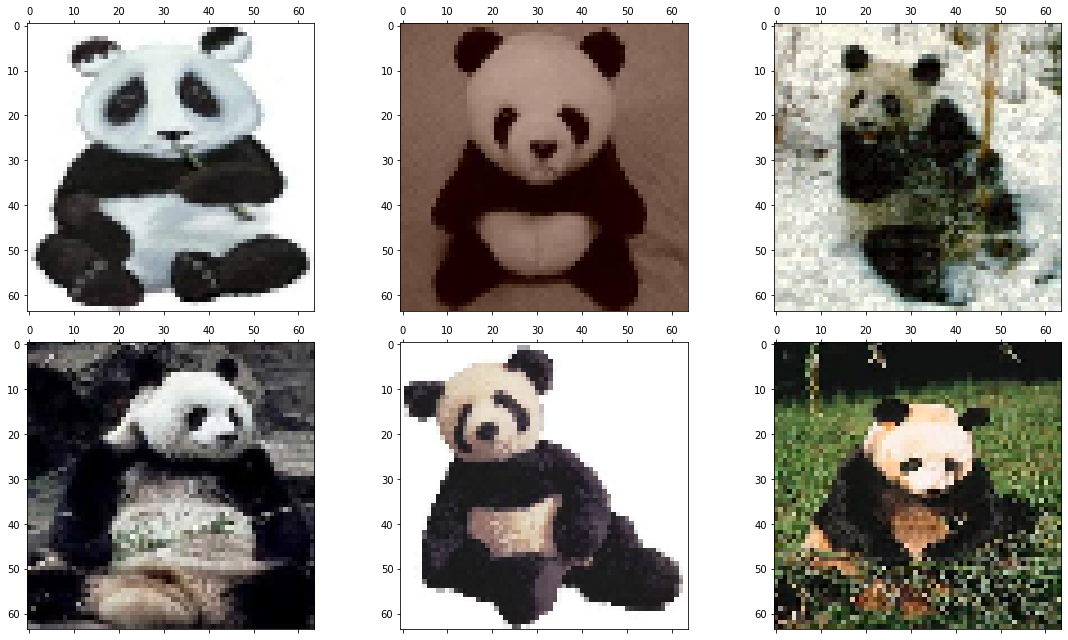

In [5]:
# Display images of 6 pandas in the training set (low resolution 64 x 64 pixels)
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,3):
        axs[i,j].matshow(X_train[n])
        n=n+1
plt.show() 

##### Higher resolution (256 x 256 pixels)

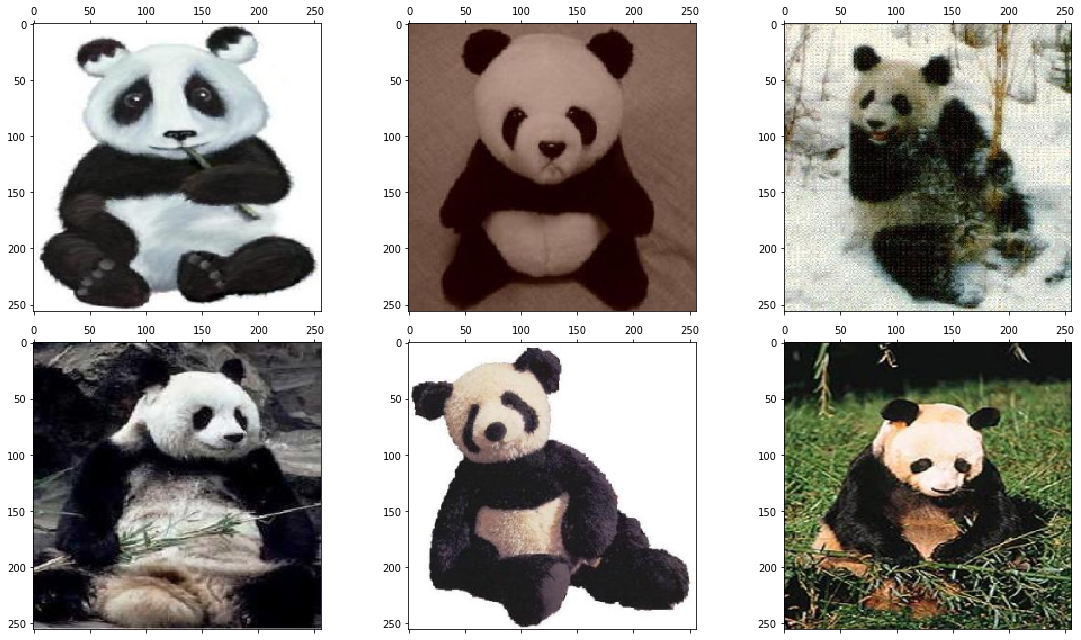

In [6]:
# Display images of 6 pandas in the test set (higher resolution 256 x 256 pixels)
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,3):
        axs[i,j].matshow(Y_train[n])
        n=n+1
plt.show() 

### Step 3 - Train a Deep Convolutional Neural Network with Transposed Convolutions 

Model: "Transposed-Convolutional-NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 Transpose-Conv2D-Layer-1 (C  (None, 128, 128, 64)     832       
 onv2DTranspose)                                                 
                                                                 
 Transpose-Conv2D-Layer-2 (C  (None, 256, 256, 128)    32896     
 onv2DTranspose)                                                 
                                                                 
 Output-Layer (Conv2D)       (None, 256, 256, 3)       3459      
                                                                 
Total params: 37,187
Trainable params: 37,187
Non-trainable params: 0
_________________________________________________________________


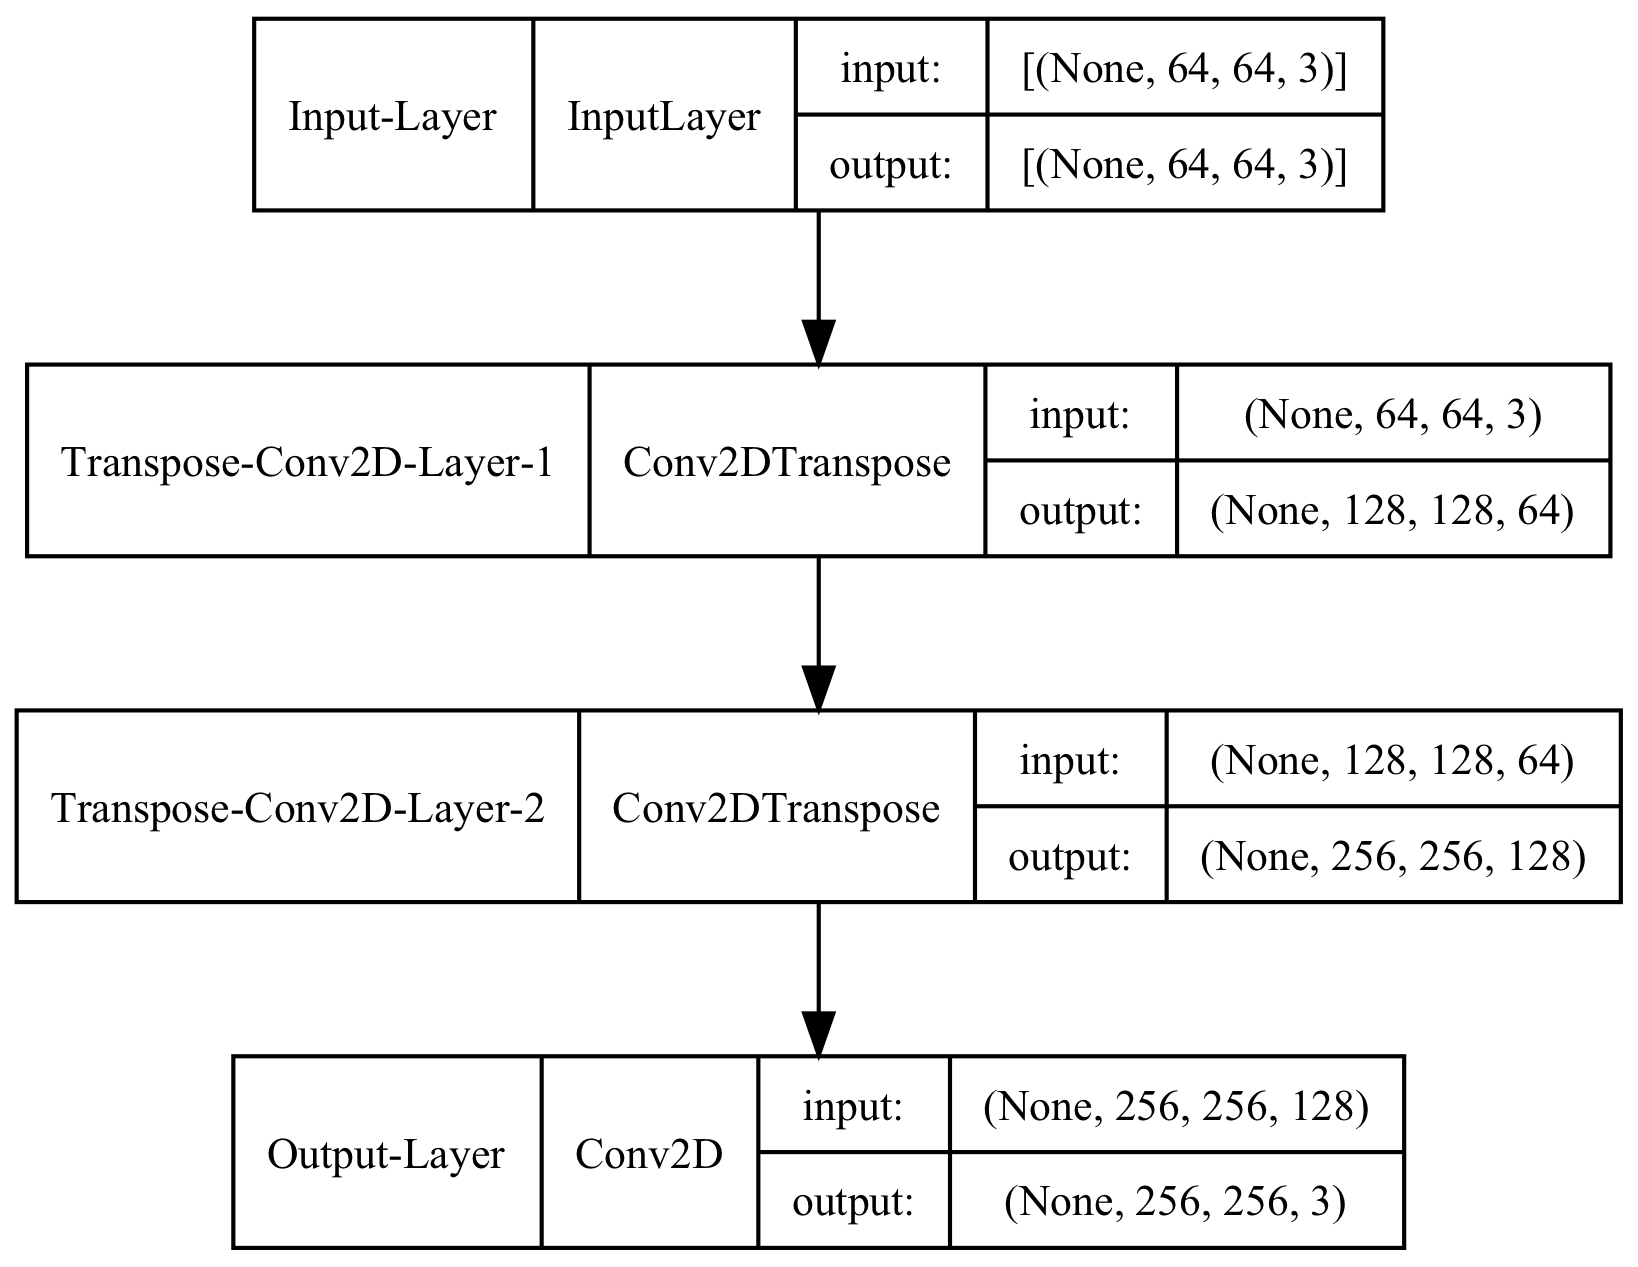

In [17]:
#--- Define Shapes
input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]) # Specify input shape

#--- Input Layer 
inputs = Input(shape=input_shape, name='Input-Layer')

#--- Upsampling from 64x64 to 256x256 using Transposed Convolutions
d = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2,2), activation="relu", padding="same", name='Transpose-Conv2D-Layer-1')(inputs)
d = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2,2), activation="relu", padding="same", name='Transpose-Conv2D-Layer-2')(d)
# Added Convolutional layer to bring the number of filters down to 3
outputs = Conv2D(filters=3, kernel_size=(3, 3), activation="sigmoid", padding="same", name='Output-Layer')(d)

#--- Assemble a model
model = Model(inputs, outputs, name='Transposed-Convolutional-NN')
model.compile(optimizer="adam", loss="mse", metrics=["Accuracy"])

#--- Print model summary
model.summary()

#--- Display model diagram
plot_model(model, show_shapes=True, dpi=300)
#plot_model(model, to_file=main_dir+'/pics/Transposed_Convolutional_Network.png', show_shapes=True, dpi=300)

In [18]:
# Train Transpose Convolutional model
history = model.fit(X_train, Y_train, epochs=100, batch_size=2, verbose=1, validation_data=(X_test, Y_test), validation_freq=5)


Epoch 1/100
15/15 [==============================] - 9s 592ms/step - loss: 0.1157 - Accuracy: 0.5842
Epoch 2/100
15/15 [==============================] - 8s 508ms/step - loss: 0.0851 - Accuracy: 0.6235
Epoch 3/100
15/15 [==============================] - 8s 507ms/step - loss: 0.0661 - Accuracy: 0.5726
Epoch 4/100
15/15 [==============================] - 8s 514ms/step - loss: 0.0453 - Accuracy: 0.5132
Epoch 5/100
15/15 [==============================] - 8s 553ms/step - loss: 0.0272 - Accuracy: 0.4639 - val_loss: 0.0236 - val_Accuracy: 0.4720
Epoch 6/100
15/15 [==============================] - 8s 510ms/step - loss: 0.0190 - Accuracy: 0.6055
Epoch 7/100
15/15 [==============================] - 7s 480ms/step - loss: 0.0170 - Accuracy: 0.6674
Epoch 8/100
15/15 [==============================] - 8s 515ms/step - loss: 0.0164 - Accuracy: 0.6700
Epoch 9/100
15/15 [==============================] - 8s 563ms/step - loss: 0.0152 - Accuracy: 0.5749
Epoch 10/100
15/15 [=============================

### Predict

In [22]:
# Take two images: one from train and another from test data
train_img_indx=6
test_img_indx=5
train_image=X_train[train_img_indx]
test_image=X_test[test_img_indx]

# The current shape of these image arrays are [rows, columns, channels].
# Add an extra dimension to make it [samples, rows, columns, channels] that is required by the model
train_image = train_image[np.newaxis, ...]
test_image = test_image[np.newaxis, ...]

# Use our Transpose Convolutional Model to upscale these images
train_img_upscale = model.predict(train_image)
test_img_upscale = model.predict(test_image)

# Reshape data back from [samples, rows, columns, channels] to [rows, columns, channels] to show the images
train_img_upscale=train_img_upscale.reshape(256, 256, 3)
test_img_upscale=test_img_upscale.reshape(256, 256, 3)

##### Example from Train data

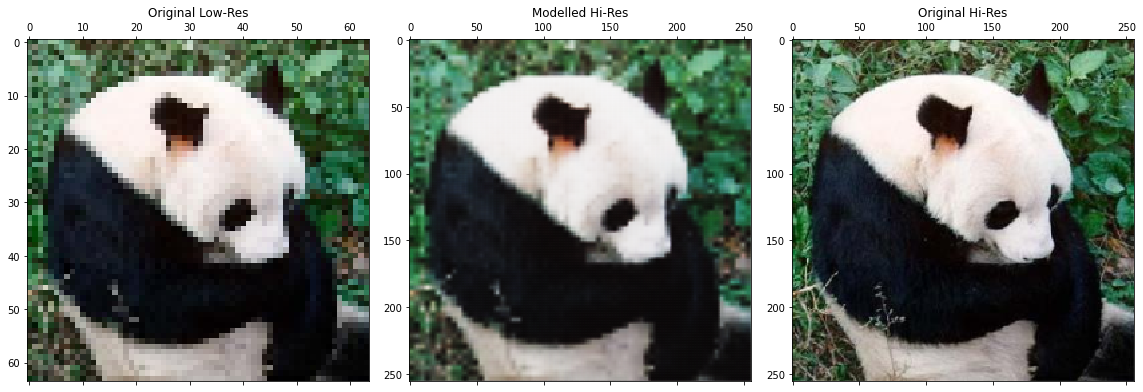

In [23]:
# Display image comparisons for train example
fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
axs[0].matshow(X_train[train_img_indx])
axs[0].set(title='Original Low-Res')
axs[1].matshow(train_img_upscale)
axs[1].set(title='Modelled Hi-Res')
axs[2].matshow(Y_train[train_img_indx])
axs[2].set(title='Original Hi-Res')
plt.show() 

##### Example from Test data

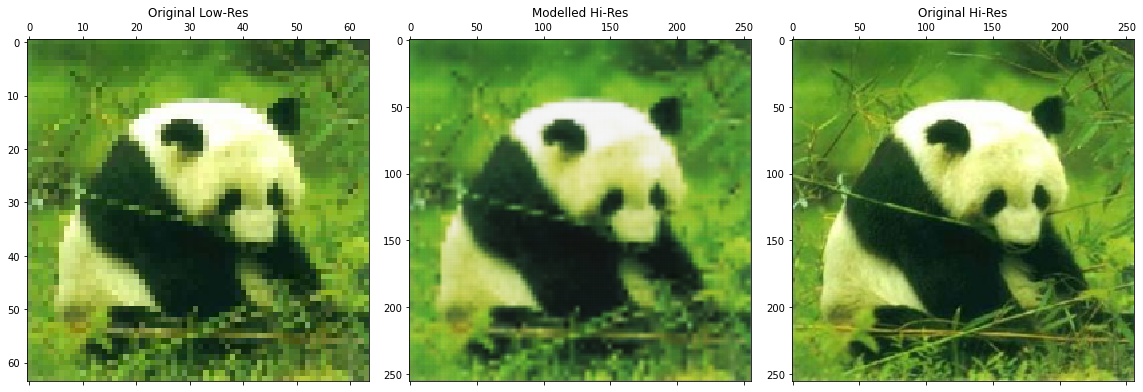

In [24]:
# Display image comparisons for test example
fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True, figsize=(16,9), facecolor='white')
axs[0].matshow(X_test[test_img_indx])
axs[0].set(title='Original Low-Res')
axs[1].matshow(test_img_upscale)
axs[1].set(title='Modelled Hi-Res')
axs[2].matshow(Y_test[test_img_indx])
axs[2].set(title='Original Hi-Res')
plt.show() 

# End of Program